# caption fine tuning

Following the huggingface tutorial [Image captioning](https://huggingface.co/docs/transformers/main/tasks/image_captioning)
which fine tunes an impage caption model.

In [2]:
from datasets import load_dataset
import torch

DATA_DIR = "data"

def pick_device() -> torch.device:
    if torch.backends.mps.is_available():
        print("Using mps backend")
        return torch.device("mps")
    if torch.cuda.is_available():
        print("Using cuda backend")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        return torch.device("cuda")
    print('No GPU available, using the CPU.')
    return torch.device("cpu")

def device_memory_allocated(device) ->float:
    if device.type == 'cuda':
        return torch.cuda.memory_summary(device=device, abbreviated=True)
    if device.type == 'mps':
        import torch.mps
        return torch.mps.current_allocated_memory()
    return 0

device = pick_device()

ds = load_dataset("lambdalabs/pokemon-blip-captions", cache_dir=DATA_DIR)
ds

Using mps backend


DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

In [3]:
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

# Examine Dataset

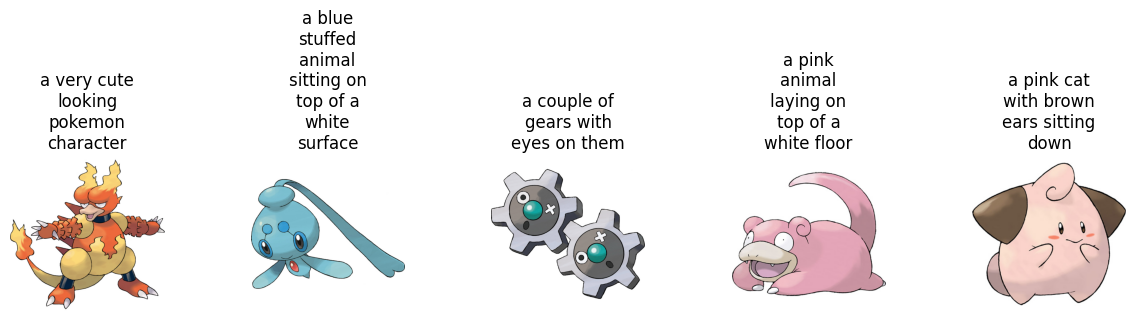

In [4]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images: list, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")

# sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
# sample_captions = [train_ds[i]["text"] for i in range(5)]
# plot_images(sample_images_to_visualize, sample_captions)

it = iter(train_ds)

nrows, ncols = 1, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
for i in range(0, ncols):
    sample = next(it)
    ax = axes[i]
    ax.axis('on')
    caption = sample['text']
    caption = "\n".join(wrap(caption, 12))
    ax.set_title(caption)
    ax.axis("off")
    ax.imshow(sample['image'])
plt.show()


# Preprocess Dataset

In [5]:
from transformers import AutoProcessor

# GenerativeImage2Text model from https://arxiv.org/abs/2205.14100
checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint, cache_dir=DATA_DIR)

def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs

train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

# Base Model

In [15]:
from pathlib import Path

MODEL_NAME = checkpoint.split("/")[1]
SAVE_CHECKPOINT_DIR = f"{MODEL_NAME}-pokemon"

eligible_checkpoint: str | None = None
if Path(SAVE_CHECKPOINT_DIR).exists():
    checkpoints = list(Path(SAVE_CHECKPOINT_DIR).glob("checkpoint-*"))
    checkpoints.sort()
    if checkpoints:
        eligible_checkpoint = str(checkpoints[-1])

In [16]:
from transformers import AutoModelForCausalLM

print(f"Memory: {device_memory_allocated(device)}")

if eligible_checkpoint:
    print(f"Loading from trained save checkpoint {eligible_checkpoint}")
    model = AutoModelForCausalLM.from_pretrained(eligible_checkpoint, cache_dir=DATA_DIR).to(device)
else:
    print("Loading from checkpoint")
    model = AutoModelForCausalLM.from_pretrained(checkpoint, cache_dir=DATA_DIR).to(device)

print(sum([p.numel() for p in model.parameters()]))
print(f"Memory: {device_memory_allocated(device)}")


Memory: 2574268672
Loading from trained save checkpoint git-base-pokemon/checkpoint-220
176619066
Memory: 2414150912


# Evaluate

In [17]:
from evaluate import load
import torch

# Word Error Rate: https://huggingface.co/spaces/evaluate-metric/wer - a metric
# for measuring word sequence error rates.
wer = load("wer")

def preprocess_logits_for_metrics(logits: torch.tensor, labels: torch.tensor) -> torch.tensor:
    """
    Original Trainer may have a memory leak. 
    This is a workaround to avoid storing too many tensors that are not needed.
    https://discuss.huggingface.co/t/cuda-out-of-memory-when-using-trainer-with-compute-metrics/2941/1
    """
    return logits.argmax(-1)

def compute_metrics(eval_pred: tuple[torch.tensor, torch.tensor]):
    print(f"Memory: {device_memory_allocated(device)}")
    predicted, labels = eval_pred
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

# Train

In [18]:
from accelerate import Accelerator
from transformers import TrainingArguments, Trainer, TrainerCallback
from transformers.optimization import Adafactor, AdafactorSchedule
from torch.utils.data.dataloader import DataLoader
from transformers.trainer_callback import TrainerControl, TrainerState
from transformers.training_args import TrainingArguments

lr = 0


training_args = TrainingArguments(
    output_dir=SAVE_CHECKPOINT_DIR,
    num_train_epochs=10,
    #fp16=True,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=10,
    save_strategy="steps",
    save_steps=10,
    logging_steps=10,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    # Save ram
    optim="adafactor",
)

class PrintStatsCb(TrainerCallback):
    def on_epoch_begin(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kwargs):
        super().on_epoch_begin(args, state, control, **kwargs)
        print(f"Epoch: Device Memory: {device_memory_allocated(device)}")


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    callbacks=[PrintStatsCb()]
)
result = trainer.train()
print(result)

  0%|          | 0/930 [00:00<?, ?it/s]

Epoch: Device Memory: 2414151168


KeyboardInterrupt: 

# Inference

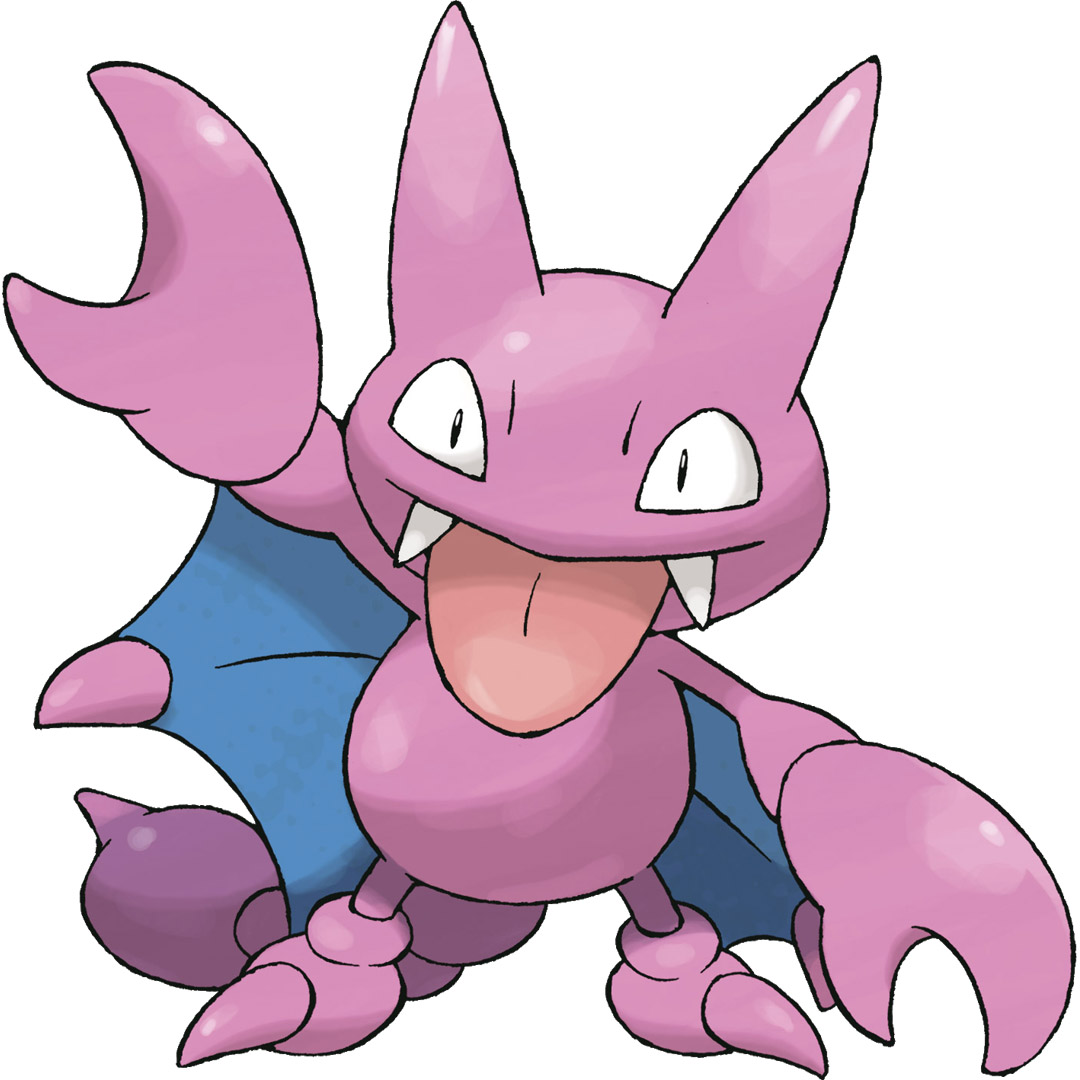

In [11]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
image

In [12]:
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

/Users/allen/Development/ml-papers/venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/Users/allen/Development/ml-papers/venv/lib/python3.11/site-packages/transformers/generation/utils.py:2419: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  if unfinished_sequences.max() == 0:


a cartoon character with a pink and blue tail
